In [4]:
# unzip the snapshots file
!unzip -q "/content/snapshots.zip" -d "/content/snapshots"

replace /content/snapshots/snapshots/epoch6_snap_3.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
# setting up device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [30]:
# defne a get_model function that gets model from path that works for both gpu and cpu
def get_model(path):
  if device.type == 'cpu':
    model = torch.load(path, map_location=torch.device('cpu'))
  else:
    model = torch.load(path)
  return model

In [31]:
# loads the final snapshot of the model
model = get_model('snapshots/snapshots/epoch10_snap_final.pt')

In [32]:
print(model.keys())

odict_keys(['l1.weight', 'l1.bias', 'l2.weight', 'l2.bias', 'l3.weight', 'l3.bias'])


In [33]:
model['l1.weight'].shape

torch.Size([784, 784])

In [34]:
# get layer 1 weights as numpy a['model_state_dict']rray
layer1_weights = model['l1.weight'].numpy()

to get an idea of which patterns does the network look for in images, I will print random samples of the weights connected to a neuron in the first hidden layer.

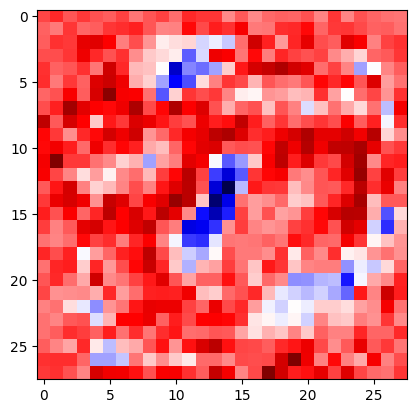

In [35]:
# get neuron 1 as image
neuron1 = layer1_weights[0].reshape(28, 28)

# plot it red
import matplotlib.pyplot as plt
plt.imshow(neuron1, cmap='seismic')
plt.show()

Ok there are some red and blue patches. Let us see how this one neuron evolved over time

In [26]:
neuron1_over_time = []

# we begin with initial model
model = get_model('snapshots/snapshots/epoch0_snap_initial.pt')
neuron1_over_time.append(model['l1.weight'][0].numpy().reshape(28, 28))


# iterate though all files in snapshots/snapshots
for i in range(1, 11):
  for j in range(2, 5):
    # load the model
    model = get_model(f'snapshots/snapshots/epoch{i}_snap_{j}.pt')
    neuron1_over_time.append(model['l1.weight'][0].numpy().reshape(28, 28))

# then we add the final model
model = get_model('snapshots/snapshots/epoch10_snap_final.pt')
neuron1_over_time.append(model['l1.weight'][0].numpy().reshape(28, 28))

In [29]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# animate it
fig, ax = plt.subplots()
im = ax.imshow(neuron1_over_time[0], cmap='seismic')

def update(i):
    im.set_data(neuron1_over_time[i])
    return im,

ani = FuncAnimation(fig, update, frames=len(neuron1_over_time), interval=100, blit=True)
plt.close()
# convert to html for colab
HTML(ani.to_jshtml())

The jHtml renders it somewhat different. But there is a clear pattern of how it was learned. Next try it with more neurons.

In [59]:
import numpy as np
neurons_idx = np.linspace(0, 783, 9).astype(int)
print(neurons_idx)

[  0  97 195 293 391 489 587 685 783]


In [60]:
# pick 9 neurons as samples
neurons_over_time = []

for k in neurons_idx:
  model = get_model('snapshots/snapshots/epoch0_snap_initial.pt')
  neurons_over_time.append([model['l1.weight'][k].numpy().reshape(28, 28)])

  for i in range(1, 11):
    for j in range(2, 5):
      model = get_model(f'snapshots/snapshots/epoch{i}_snap_{j}.pt')
      neurons_over_time[-1].append(model['l1.weight'][k].numpy().reshape(28, 28))

  model = get_model('snapshots/snapshots/epoch10_snap_final.pt')
  neurons_over_time[-1].append(model['l1.weight'][k].numpy().reshape(28, 28))

In [50]:
len(neurons_over_time)

8

In [74]:
# building the animation
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
flat_axes = axes.flat

ims = []

for i in range(len(flat_axes)):
  ax = flat_axes[i]
  ims.append(ax.imshow(neurons_over_time[i][0], cmap='seismic'))
  ax.axis('off')

def update(i):
  for j in range(len(flat_axes)):
    ims[j].set_data(neurons_over_time[j][i])
    flat_axes[j].set_title(f'Neuron {neurons_idx[j]} at snapshot {i}')
  return ims

ani = FuncAnimation(fig, update, frames=len(neurons_over_time[0]), interval=100, blit=True)
plt.close()
# convert to html for colab
HTML(ani.to_jshtml())

It looks like all nodes learned to get activated at a bunch of patches (red), and to get deactivated at a bunch of patches(blue).  
So it already learned 'spatial structure' (to link pixels that are in the same region to each other) in the first layer!!

Now for clustering on the first layer. I suspect that one problem of this is that in our similarity metric, we consider all basis vectors (nodes in the first hidden layer) to be independent when we should be more careful. One possible solution is to cluster backwards and define our own similarity measure that takes the cluster of the basis vector into account.

In [75]:
# get final model's layer 1 weights
model = get_model('snapshots/snapshots/epoch10_snap_final.pt')
layer1_weights = model['l1.weight'].numpy()

# Transpose to get input nodes as rows
feature_matrix = layer1_weights.T

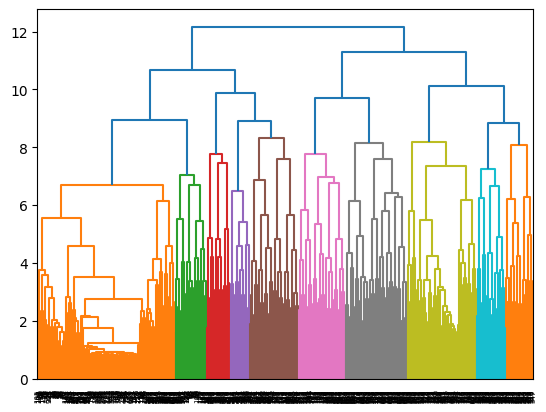

In [76]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

distance_matrix = linkage(feature_matrix, method='ward', metric='euclidean')

# plot the dendogram
dendrogram(distance_matrix)
plt.show()

scipy thinks we have 10 clusters, is it related to the fact that we have 10 digits?  
For comparision here is a dendogram that would be created if all the elements in the matrix were ordered randomly.

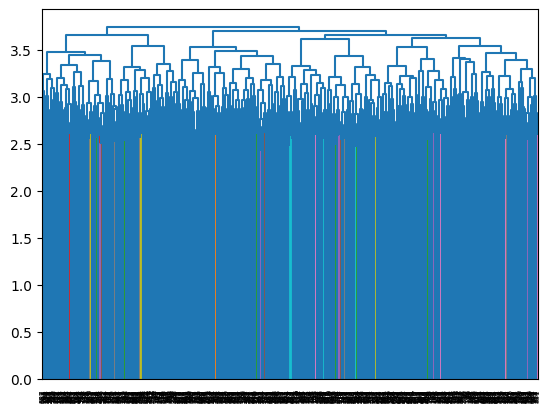

In [90]:
X_flat = feature_matrix.flatten()
np.random.shuffle(X_flat)
X_shuffled = X_flat.reshape(feature_matrix.shape)

Z_shuffled = linkage(X_shuffled, method='ward')
dendrogram(Z_shuffled)
plt.show()

In [91]:
# gettting the clusters

max_clusters = 10 # going with scipy's suggesstion
clusters = fcluster(distance_matrix, max_clusters, criterion='maxclust')

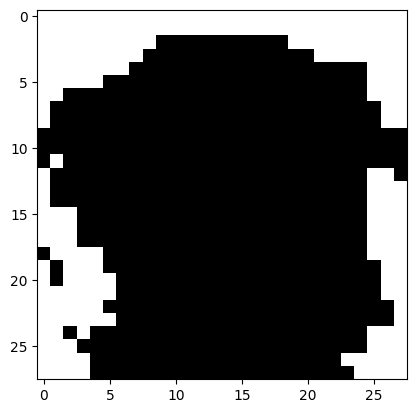

In [97]:
# draw the pixels of the first cluster
cluster1 = clusters == 1
plt.imshow(cluster1.reshape(28, 28), cmap='gray')
plt.show()

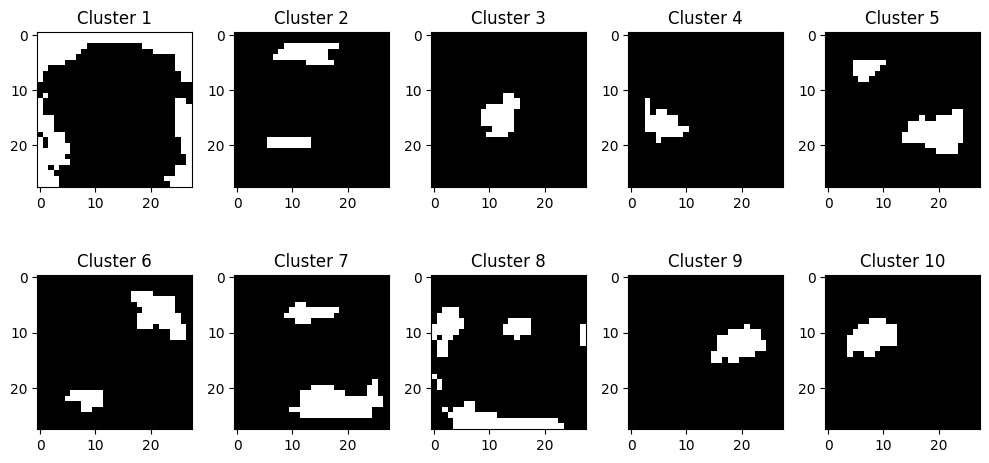

In [106]:
# draw the pixels for each cluster
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
flat_axes = axes.flat
for i in range(10):
  ax = flat_axes[i]
  cluster = clusters == i+1
  ax.imshow(cluster.reshape(28, 28), cmap='gray')

  # set the title
  ax.set_title(f'Cluster {i+1}')

plt.tight_layout()
plt.show()

Suprrisingly, the clusters actually amount to patches. Just to make sure, let us compute it using k-means clustering

In [107]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(feature_matrix)

In [108]:
labels = kmeans.labels_

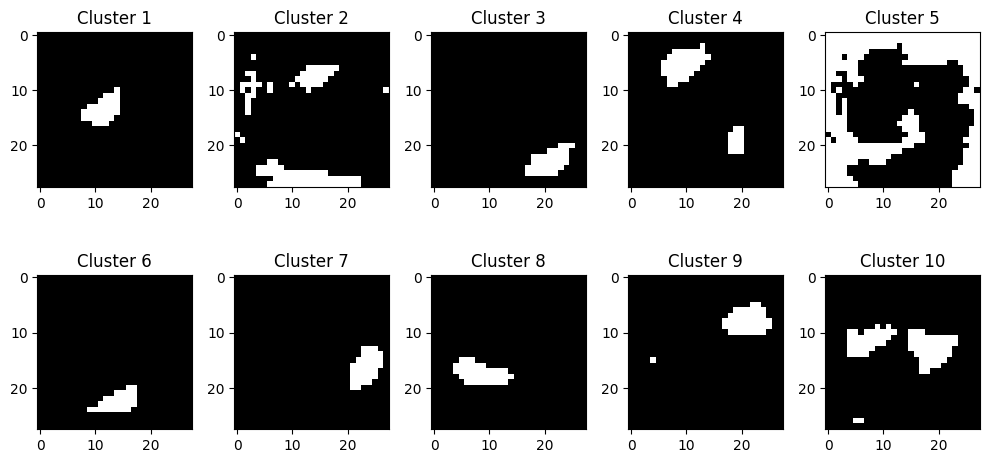

In [112]:
# draw the pixels for each cluster
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
flat_axes = axes.flat
for i in range(10):
  ax = flat_axes[i]
  label = labels == i
  ax.imshow(label.reshape(28, 28), cmap='gray')

  # set the title
  ax.set_title(f'Cluster {i+1}')

plt.tight_layout()
plt.show()

It shows a similar result. One weird thing is that one cluster contains all borders except the bottom border, which in both cases is grouped with patches above in the same place.

In [136]:
# sort the rows based on hierachical clstering
feature_matrix_sorted_rows = feature_matrix[clusters.argsort()]

# sort the columns as well by fisrt transposing then clustering again
feature_matrix_sorted_columns = feature_matrix_sorted_rows.T
# create distance matrix
new_distance_matrix = linkage(feature_matrix_sorted_columns, method='ward', metric='euclidean')

num_clusters = 10
new_clusters = fcluster(new_distance_matrix, num_clusters, criterion='maxclust')

# sort the rows again
feature_matrix_sorted = feature_matrix_sorted_rows[new_clusters.argsort()]

Visualizing as a bipartite graph.

In [137]:
# taking abolute value turned out to be a bad idea; it reduced the structure of the graph,
# probably becuase it confuses positive evidence with negative evidence
# feature_matrix_sorted = np.abs(feature_matrix_sorted)

 # finding the mean weight to set it as the threshold
threshold = np.mean(feature_matrix_sorted)
print(threshold)

-0.011724599


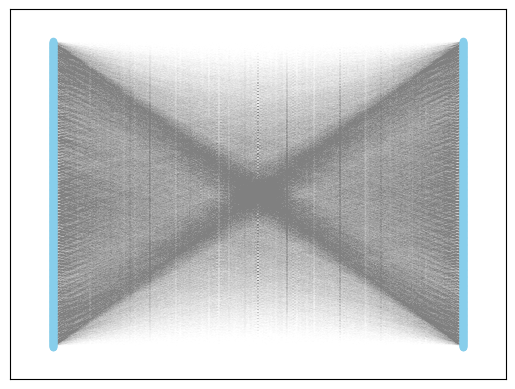

In [138]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# matrix
matrix = feature_matrix_sorted >= threshold

G = nx.Graph()

# Add row nodes
row_nodes = [f"r{i}" for i in range(matrix.shape[0])]
col_nodes = [f"c{j}" for j in range(matrix.shape[1])]

# Add edges with weights
for i, r in enumerate(row_nodes):
    for j, c in enumerate(col_nodes):
        weight = matrix[i, j]
        if weight != 0:
            G.add_edge(r, c, weight=weight)

# Position the nodes in two layers
pos = {}
pos.update((n, (0, i)) for i, n in enumerate(row_nodes))
pos.update((n, (1, i)) for i, n in enumerate(col_nodes))

# Draw
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray', width=0.01)  # translucent edges

plt.show()


There seems to be no prominant features except for the prominant X, but to make sure it is not a visual tick or caused by order of drawing, I will reverse the rows of teh matrix and graph it again. If the X is due to clusters, it should transform to two parallel lines.

In [139]:
feature_matrix_reversed = feature_matrix_sorted_rows[::-1]

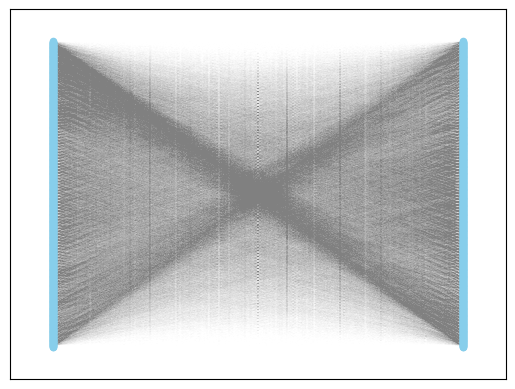

In [140]:
# matrix
matrix = feature_matrix_reversed >= threshold

G = nx.Graph()

# Add row nodes
row_nodes = [f"r{i}" for i in range(matrix.shape[0])]
col_nodes = [f"c{j}" for j in range(matrix.shape[1])]

# Add edges with weights
for i, r in enumerate(row_nodes):
    for j, c in enumerate(col_nodes):
        weight = matrix[i, j]
        if weight != 0:
            G.add_edge(r, c, weight=weight)

# Position the nodes in two layers
pos = {}
pos.update((n, (0, i)) for i, n in enumerate(row_nodes))
pos.update((n, (1, i)) for i, n in enumerate(col_nodes))

# Draw
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray', width=0.01)  # translucent edges

plt.show()

Still an X this means it is not an actual feature, and also means this drawing library is not ideal ?!